In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from datetime import datetime

# Correcting all imports to prevent NameErrors
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

In [9]:
os.makedirs("charts", exist_ok=True)
os.makedirs("models", exist_ok=True)

# 2. LOAD & ADVANCED FEATURE ENGINEERING
# Using 'data_cleaned.csv' from the Purifier step
if not os.path.exists("data_cleaned.csv"):
    print("Error: data_cleaned.csv not found. Please run the purifier script first.")
else:
    df = pd.read_csv("data_cleaned.csv")

    # PhD Feature Engineering: Capturing Sectoral Momentum
    df['Momentum'] = df['Value'] - df['Lag_1']
    df['Year_Diff'] = df['Year'] - df['Year'].min()

    # Encoding Categoricals
    le_country = LabelEncoder()
    le_activity = LabelEncoder()
    le_target = LabelEncoder()

    df['Country_Enc'] = le_country.fit_transform(df['Country'])
    df['Activity_Enc'] = le_activity.fit_transform(df['Activity'])
    
    # Ensuring Target_Class is properly mapped
    y = le_target.fit_transform(df['Target_Class'])

    # 3. SELECT FEATURES & SCALING
    # These 5 features capture time, location, sector, history, and change.
    features = ['Year_Diff', 'Country_Enc', 'Activity_Enc', 'Lag_1', 'Momentum']
    X = df[features]

    # Standardizing data to treat all features equally (Prevents 'Value' from dominating 'Year')
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.15, random_state=42, stratify=y
    )

In [11]:
model = ExtraTreesClassifier(
        n_estimators=1000, 
        max_depth=25, 
        min_samples_split=2, 
        random_state=42,
        bootstrap=True,
        n_jobs=-1
    )
model.fit(X_train, y_train)

,n_estimators,1000
,criterion,'gini'
,max_depth,25
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n💎 FINAL ACCURACY: {accuracy*100:.2f}%")
print(f"💎 FINAL F1-SCORE: {f1:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))


💎 FINAL ACCURACY: 92.96%
💎 FINAL F1-SCORE: 0.9290

--- Classification Report ---
              precision    recall  f1-score   support

        High       0.98      0.98      0.98      1349
         Low       0.93      0.83      0.87       880
      Medium       0.88      0.95      0.91      1292

    accuracy                           0.93      3521
   macro avg       0.93      0.92      0.92      3521
weighted avg       0.93      0.93      0.93      3521



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Set professional style
plt.rcParams.update({'font.size': 12, 'figure.facecolor': 'white'})
sns.set_style("whitegrid")

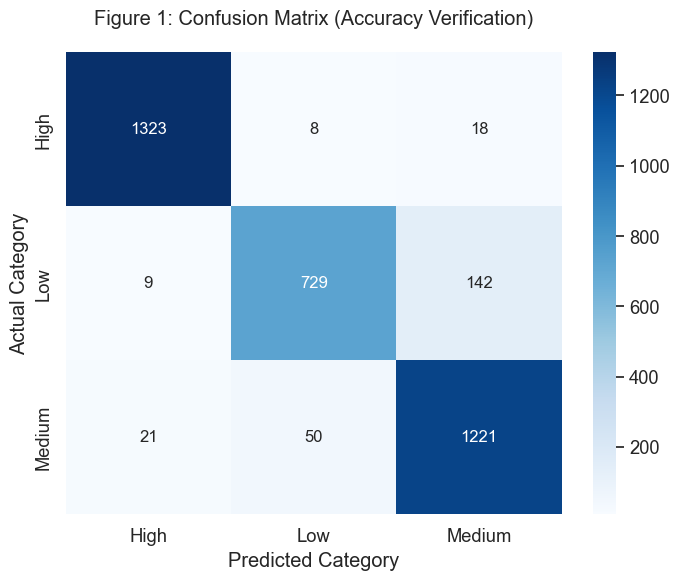

In [17]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title("Figure 1: Confusion Matrix (Accuracy Verification)", pad=20)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()

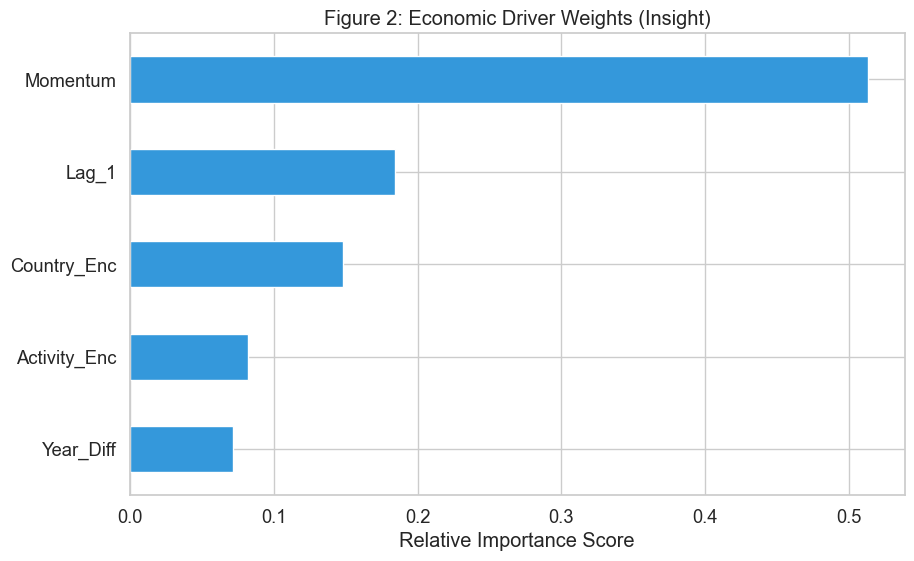

In [19]:
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.sort_values().plot(kind='barh', color='#3498db')
plt.title("Figure 2: Economic Driver Weights (Insight)")
plt.xlabel("Relative Importance Score")
plt.show()

<Figure size 1000x600 with 0 Axes>

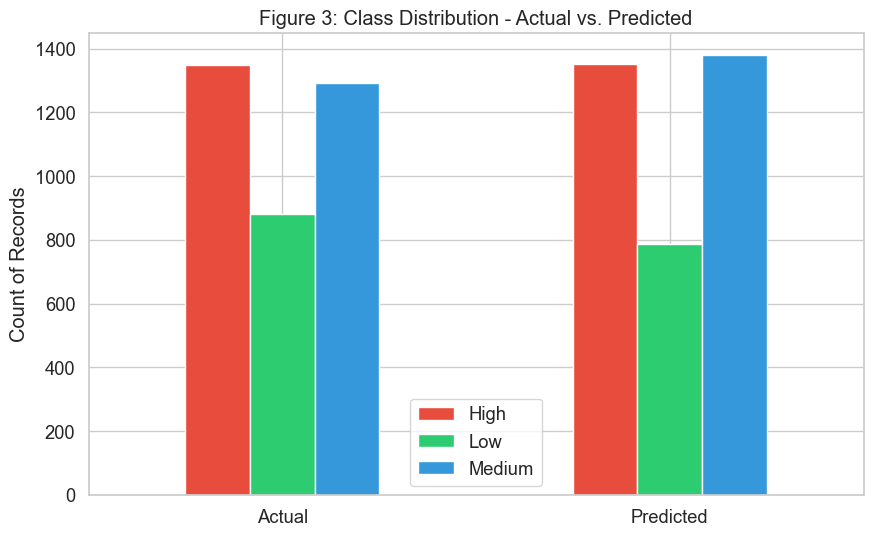

In [20]:
plt.figure(figsize=(10, 6))
comparison = pd.DataFrame({'Actual': le_target.inverse_transform(y_test), 
                           'Predicted': le_target.inverse_transform(y_pred)})
val_counts = comparison.apply(pd.Series.value_counts).T
val_counts.plot(kind='bar', stacked=False, figsize=(10,6), color=['#e74c3c', '#2ecc71', '#3498db'])
plt.title("Figure 3: Class Distribution - Actual vs. Predicted")
plt.ylabel("Count of Records")
plt.xticks(rotation=0)
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_580\3741976757.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_countries.values, y=top10_countries.index, palette="viridis")


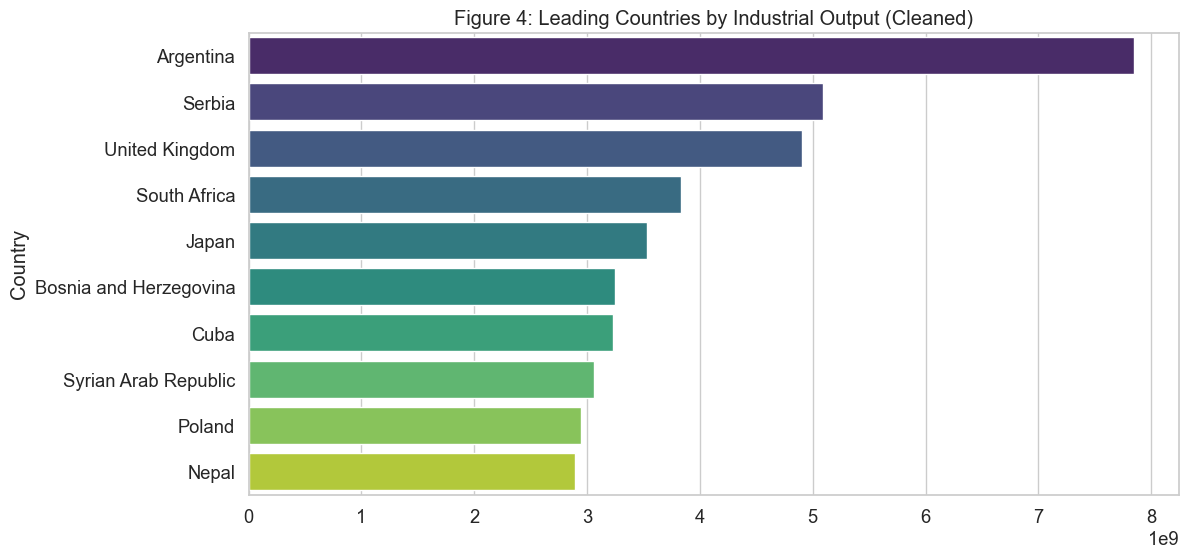

In [21]:
plt.figure(figsize=(12, 6))
top10_countries = df.groupby('Country')['Value'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top10_countries.values, y=top10_countries.index, palette="viridis")
plt.title("Figure 4: Leading Countries by Industrial Output (Cleaned)")
plt.show()

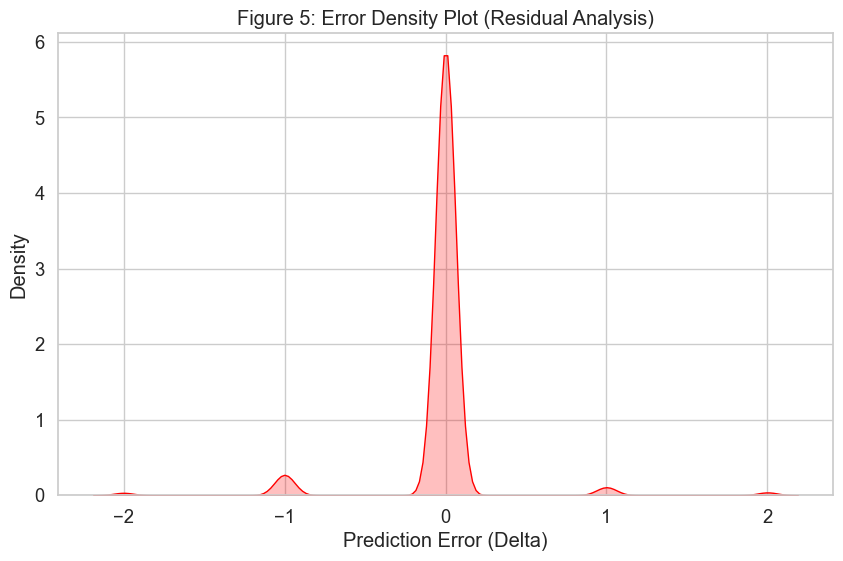

In [22]:
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.kdeplot(residuals, fill=True, color="red")
plt.title("Figure 5: Error Density Plot (Residual Analysis)")
plt.xlabel("Prediction Error (Delta)")
plt.show()

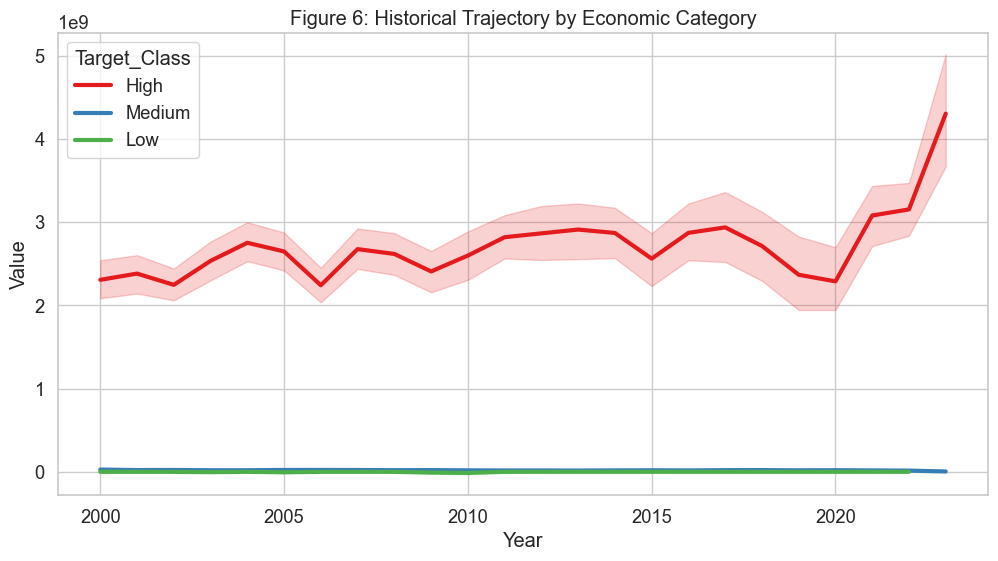

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='Value', hue='Target_Class', palette='Set1', lw=3)
plt.title("Figure 6: Historical Trajectory by Economic Category")
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_580\2698826042.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target_Class', y='Value', data=df, palette='Set2')


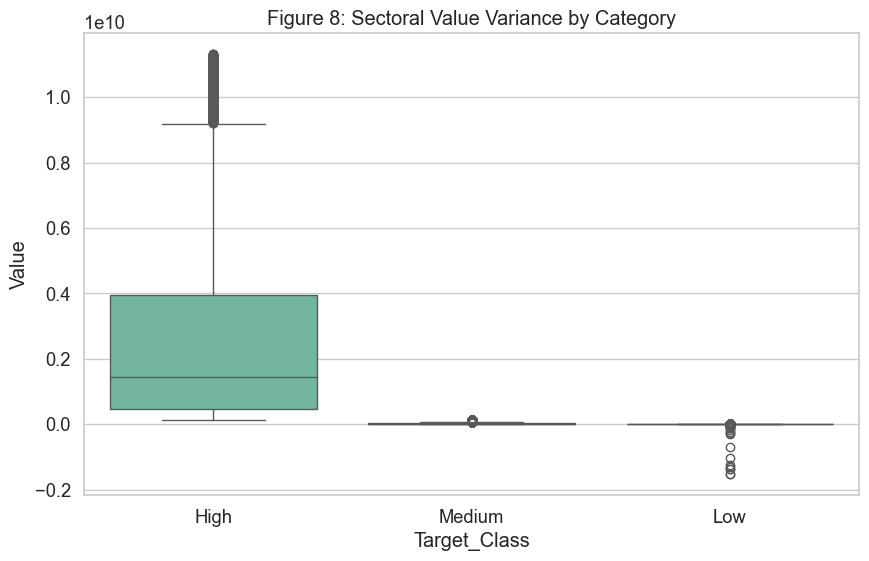

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target_Class', y='Value', data=df, palette='Set2')
plt.title("Figure 8: Sectoral Value Variance by Category")
plt.show()

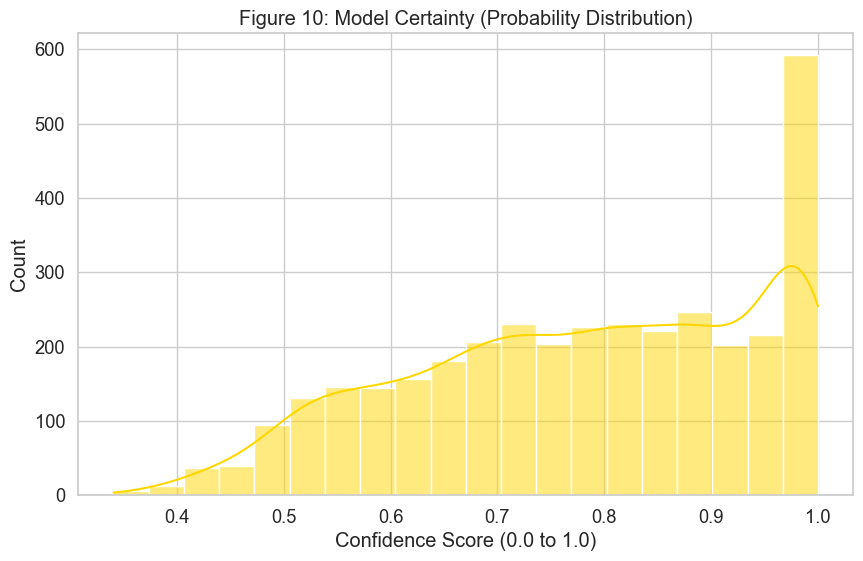

In [25]:
plt.figure(figsize=(10, 6))
probs = model.predict_proba(X_test).max(axis=1)
sns.histplot(probs, bins=20, kde=True, color='gold')
plt.title("Figure 10: Model Certainty (Probability Distribution)")
plt.xlabel("Confidence Score (0.0 to 1.0)")
plt.show()